# 2022 Fall EE5183 FinTech - Homework 2
## Deep Learning Model: Recurrent Neural Network, BERT

In [1]:
%pip install --force-reinstall numpy==1.18.5
%pip install pandas
%pip install TA-Lib
%pip install mplfinance

  Using cached numpy-1.18.5.zip (5.4 MB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
    Preparing wheel metadata: started
    Preparing wheel metadata: finished with status 'error'
Note: you may need to restart the kernel to use updated packages.


    ERROR: Command errored out with exit status 1:
     command: 'c:\Users\tadeo\anaconda3\python.exe' 'c:\Users\tadeo\anaconda3\lib\site-packages\pip\_vendor\pep517\in_process\_in_process.py' prepare_metadata_for_build_wheel 'C:\Users\tadeo\AppData\Local\Temp\tmpmvvhjf0c'
         cwd: C:\Users\tadeo\AppData\Local\Temp\pip-install-bmnacc53\numpy_709ea85854a74528a071585f1ff2ac9b
    Complete output (267 lines):
    Running from numpy source directory.
    <string>:461: UserWarning: Unrecognized setuptools command, proceeding with generating Cython sources and expanding templates
    Cythonizing sources
    Processing numpy/random\_bounded_integers.pxd.in
    Processing numpy/random\mtrand.pyx
    C:\Users\tadeo\AppData\Local\Temp\pip-install-bmnacc53\numpy_709ea85854a74528a071585f1ff2ac9b\tools\cythonize.py:75: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
      required_version = LooseVersion('0.29.14')
    C:\Users\tadeo\AppData\Local\Te

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


# Data Preparation

In [351]:
# imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split


In [352]:
import talib
import matplotlib.pyplot as plt
import mplfinance as mpf

In [435]:
df = pd.read_csv("APPLE.csv")

# modify the data to include close of next day:

df["CloseNext"] = 0
df["CloseNext"][:-1] = df["Close"][1:].copy() 
df.drop(df.tail(1).index,inplace=True)

print(f" df rows: {len(df)}")


# setting a date_time_index:
df["DateTime"] = pd.to_datetime(df['Date'])
df = df.set_index('DateTime')

print(df)

df.describe()


 df rows: 753
                  Date    Open    High     Low   Close   Volume  Adj Close  \
DateTime                                                                     
2011-01-03  2011-01-03  120.59  121.63  120.01  121.03  1893100     100.75   
2011-01-04  2011-01-04  121.78  122.25  119.46  121.86  2816000     101.44   
2011-01-05  2011-01-05  121.50  125.00  120.37  124.91  3059700     103.98   
2011-01-06  2011-01-06  125.16  125.59  121.91  122.38  2178000     101.87   
2011-01-07  2011-01-07  122.80  124.03  122.17  123.17  2035300     102.53   
...                ...     ...     ...     ...     ...      ...        ...   
2013-12-23  2013-12-23   87.04   87.63   85.87   85.96  2217600      73.15   
2013-12-24  2013-12-24   86.10   86.48   85.81   86.21   822100      73.37   
2013-12-26  2013-12-26   86.50   86.75   85.90   86.31  1232100      73.45   
2013-12-27  2013-12-27   86.39   87.04   85.88   86.68  1501400      73.77   
2013-12-30  2013-12-30   87.16   87.83   86.11   8

C:\Users\tadeo\AppData\Local\Temp\ipykernel_18840\1573461062.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["CloseNext"][:-1] = df["Close"][1:].copy()


,Open,High,Low,Close,Volume,Adj Close,CloseNext
count,753.000000,753.000000,753.000000,753.000000,7.530000e+02,753.000000,753.000000
mean,94.545193,95.519177,93.373944,94.464555,3.149972e+06,79.367968,94.417955
std,16.151141,16.342461,15.864271,16.117818,1.329395e+06,13.120734,16.091614
min,69.120000,69.450000,67.910000,68.840000,8.221000e+05,58.310000,68.840000
25%,82.910000,83.770000,81.940000,82.880000,2.377400e+06,69.920000,82.880000
50%,88.460000,89.360000,87.600000,88.460000,2.885600e+06,74.530000,88.450000
75%,103.090000,104.820000,101.750000,103.240000,3.574600e+06,86.290000,103.180000
max,133.660000,134.130000,130.640000,133.370000,1.589150e+07,111.290000,133.370000


c:\Users\tadeo\anaconda3\lib\site-packages\mplfinance\_arg_validators.py:36: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


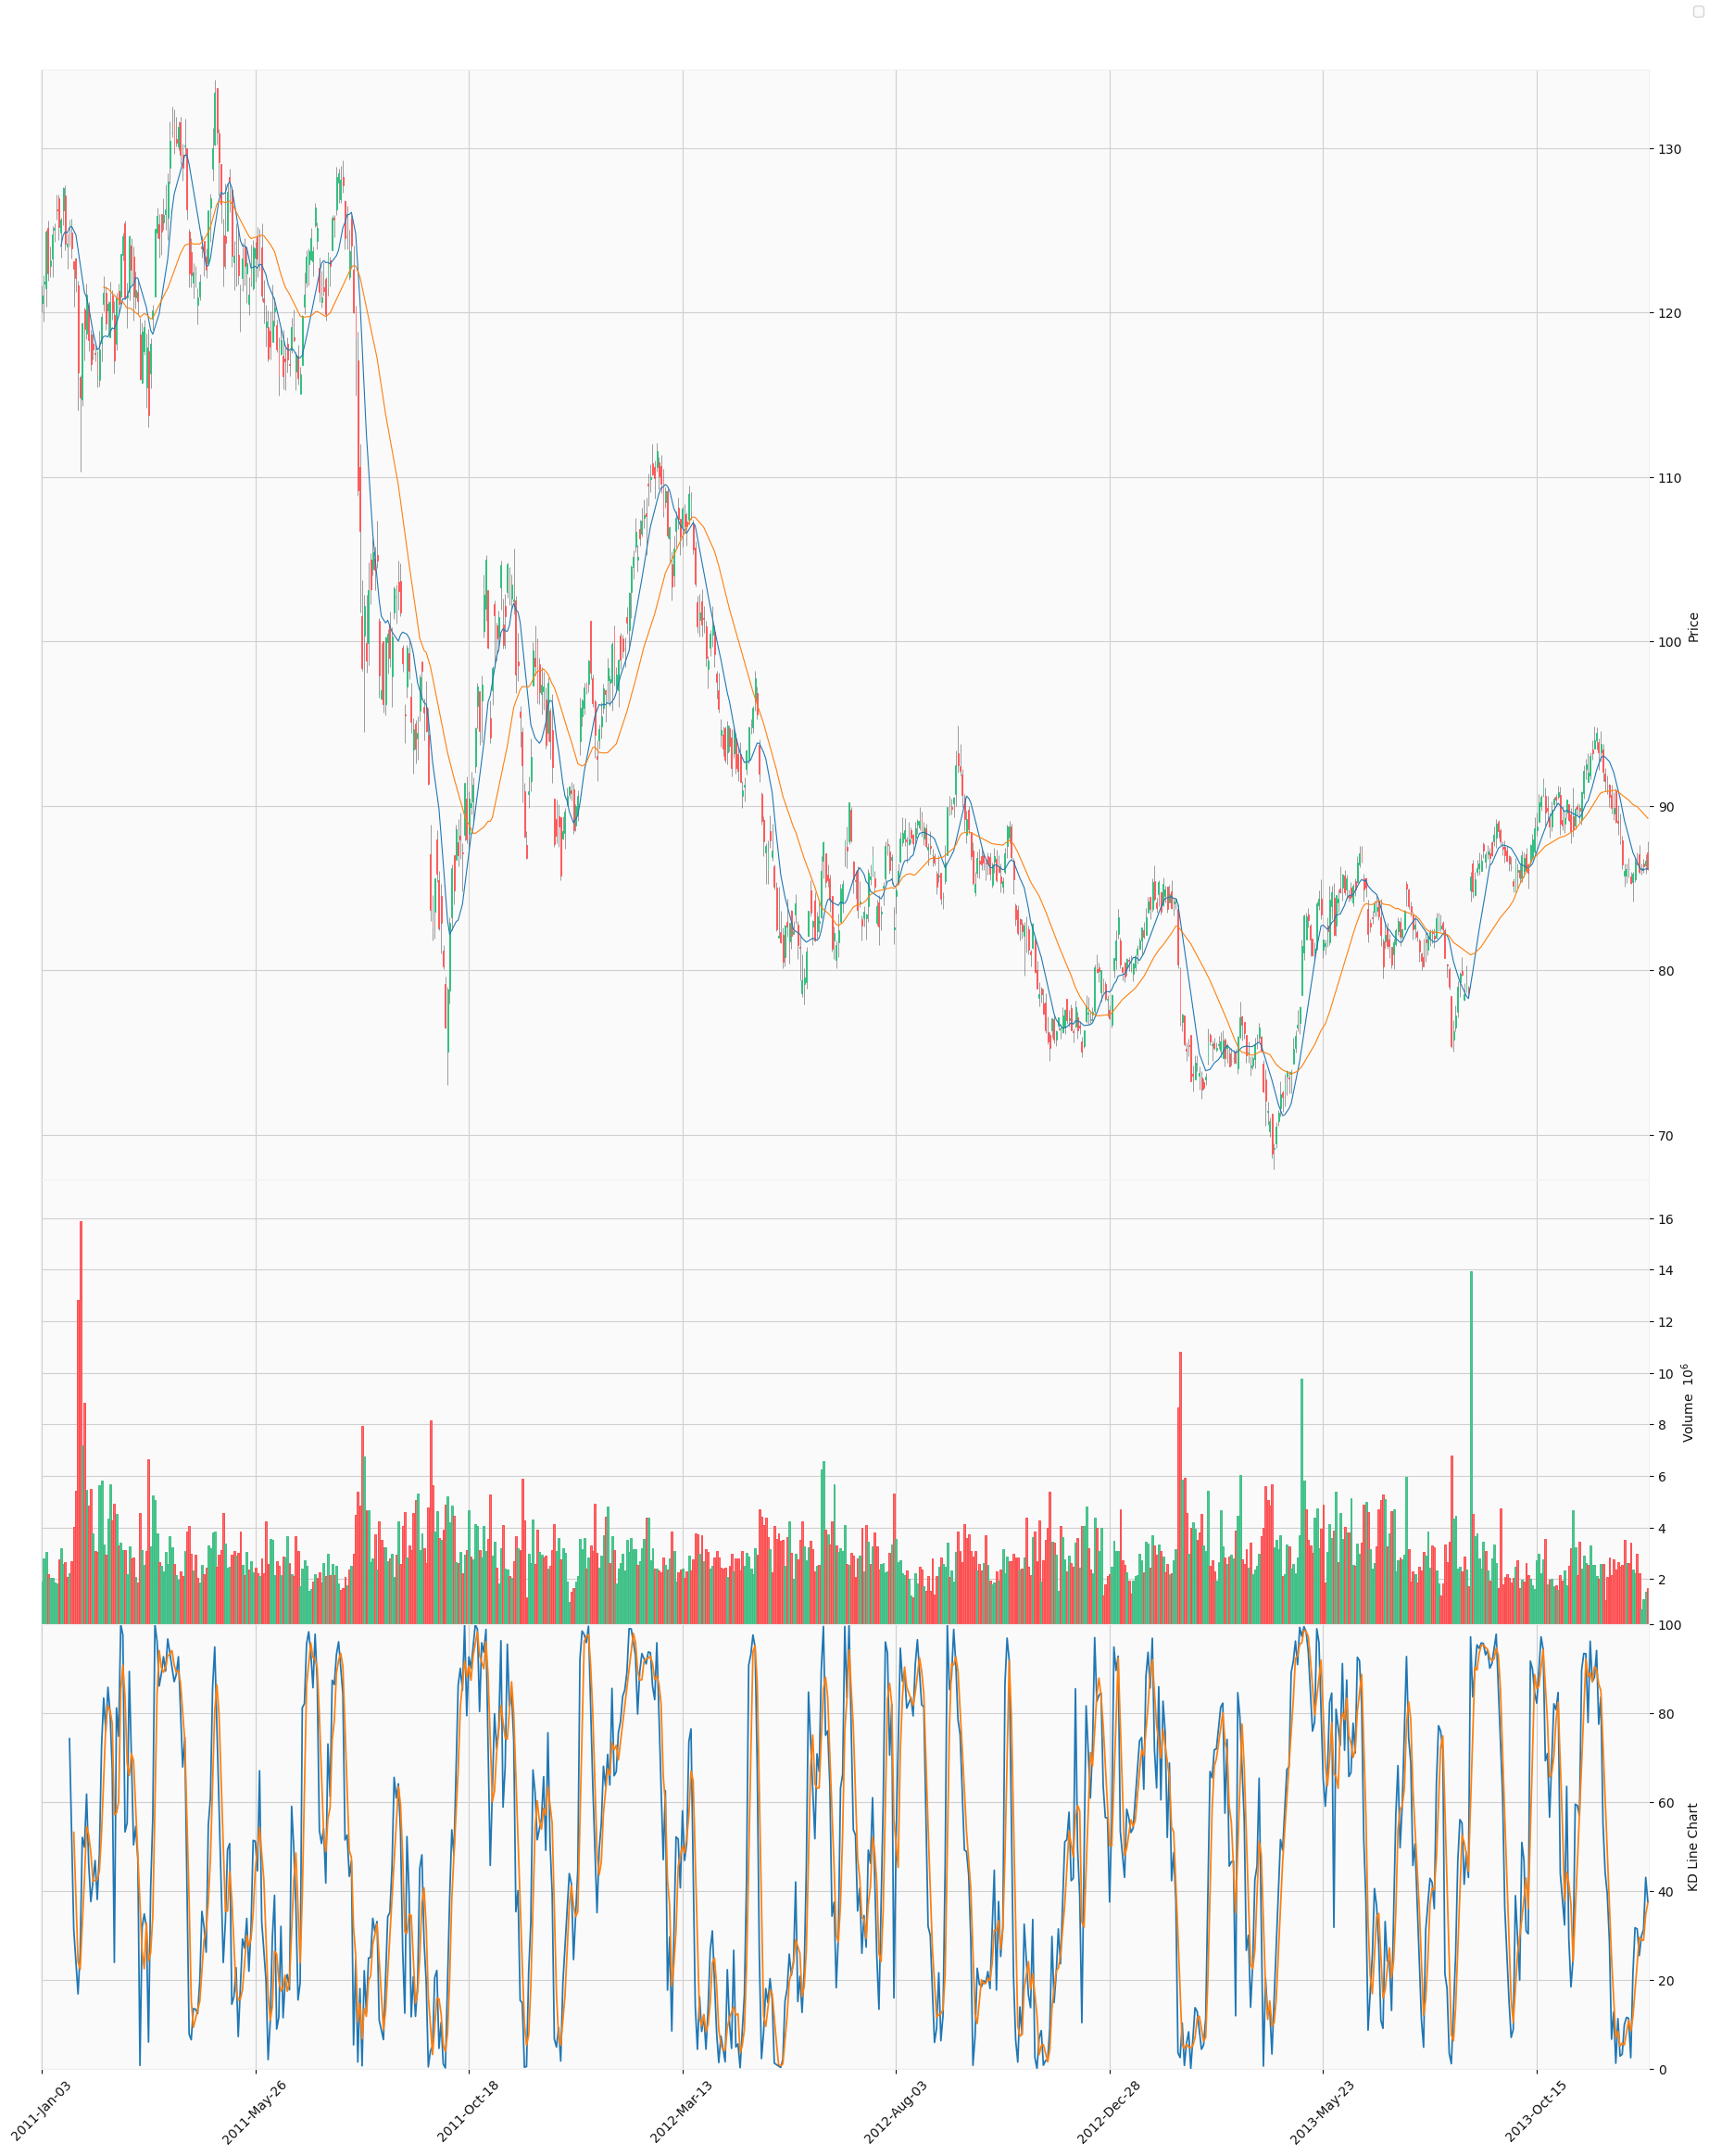

In [436]:
from matplotlib.pyplot import figure

# Stochastic
def Stochastic(df, window, smooth_window):
    stochastic = pd.DataFrame()
    stochastic['%K'] = ((df['Close'] - df['Low'].rolling(window).min()) \
                        / (df['High'].rolling(window).max() - df['Low'].rolling(window).min())) * 100
    stochastic['%D'] = stochastic['%K'].rolling(smooth_window).mean()
    # stochastic['%SD'] = stochastic['%D'].rolling(smooth_window).mean()
    # stochastic['UL'] = 80
    # stochastic['DL'] = 20
    return stochastic

stochastic = Stochastic(df, 14, 3)

stochastic_plot  =  mpf.make_addplot((stochastic[['%K', '%D']]), ylim=[0, 100], panel=2, ylabel='KD Line Chart')


fig, ax = mpf.plot(
    df,returnfig=True, type='candle', mav=(10,30), figsize=(20,25), tight_layout=True, style='yahoo',volume=True, addplot=[stochastic_plot]
)
fig.legend()
fig.savefig("images/candles_KD_volume.png")


In [437]:
# 10 Days MA, 30 Days MA, K, D
pd.set_option('display.max_rows', 10)


df["MA10"] = talib.SMA(df["Close"], 10)
df["MA30"] = talib.SMA(df["Close"], 30)
df["MA5"] = talib.SMA(df["Close"], 5)
df["K"], df["D"] = stochastic["%K"], stochastic["%D"]

df = df[~df["MA30"].isna()]
print(f" df rows: {len(df)}")


 df rows: 724


In [438]:
# min-max-normalize all numeric features:
NUMERIC_FEATURES = ["Open","High","Low","Close","MA10", "Volume","Adj Close", "MA30", "K", "D", "CloseNext"]
NUMERIC_FEATURES_NORM_FUNCS = {}
NUMERIC_FEATURES_NORM_REVERSE_FUNCS = {}

for f in NUMERIC_FEATURES:
    min = np.min(df[f])
    max = np.max(df[f])

    def gen_funcs(min, max):
        def norm_func(x):
            return (x - min) / (max-min)
        def norm_reverse_func(y):
            return y * (max -min) + min
        return norm_func, norm_reverse_func
    NUMERIC_FEATURES_NORM_FUNCS[f], NUMERIC_FEATURES_NORM_REVERSE_FUNCS[f] = gen_funcs(min,max)
    df[f] = NUMERIC_FEATURES_NORM_FUNCS[f](df[f])

NUMERIC_FEATURES.remove("CloseNext")

assert NUMERIC_FEATURES_NORM_FUNCS["Close"](NUMERIC_FEATURES_NORM_REVERSE_FUNCS["Close"](200)) == 200
df

,Date,Open,High,Low,Close,Volume,Adj Close,CloseNext,MA10,MA30,MA5,K,D
DateTime,,,,,,,,,,,,,
2011-02-14,2011-02-14,0.796095,0.815553,0.831500,0.811096,0.190770,0.805587,0.782582,0.811101,0.901377,118.462,0.833844,0.687568
2011-02-15,2011-02-15,0.806941,0.805659,0.813327,0.782582,0.161512,0.776708,0.800713,0.811718,0.900315,118.830,0.759866,0.781214
2011-02-16,2011-02-16,0.790518,0.792362,0.807907,0.800713,0.269477,0.795017,0.802417,0.810776,0.899467,119.702,0.858102,0.827207
2011-02-17,2011-02-17,0.765262,0.810297,0.806472,0.802417,0.369570,0.796716,0.792965,0.814714,0.896773,120.276,0.799747,0.815615
2011-02-18,2011-02-18,0.804307,0.802412,0.823211,0.792965,0.263465,0.787089,0.747404,0.820141,0.895285,120.332,0.675074,0.786788
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-12-23,2013-12-23,0.277657,0.281076,0.286306,0.265303,0.106326,0.280106,0.269177,0.258873,0.303613,86.022,0.254213,0.294675
2013-12-24,2013-12-24,0.263093,0.263296,0.285350,0.269177,0.000000,0.284258,0.270727,0.256014,0.301365,86.208,0.298551,0.288442
2013-12-26,2013-12-26,0.269290,0.267471,0.286785,0.270727,0.031239,0.285768,0.276461,0.255826,0.299230,86.296,0.313043,0.288006


In [439]:
# add weekdays with one hot encoding
WEEKDAYS = ["W1", "W2", "W3", "W4", "W5", "W6", "W7"]
for i,e in enumerate(WEEKDAYS):
   df[e] = 0
   df[e] = (df.index.weekday == i).astype(int)

df


,Date,Open,High,Low,Close,Volume,Adj Close,CloseNext,MA10,MA30,MA5,K,D,W1,W2,W3,W4,W5,W6,W7
DateTime,,,,,,,,,,,,,,,,,,,,
2011-02-14,2011-02-14,0.796095,0.815553,0.831500,0.811096,0.190770,0.805587,0.782582,0.811101,0.901377,118.462,0.833844,0.687568,1,0,0,0,0,0,0
2011-02-15,2011-02-15,0.806941,0.805659,0.813327,0.782582,0.161512,0.776708,0.800713,0.811718,0.900315,118.830,0.759866,0.781214,0,1,0,0,0,0,0
2011-02-16,2011-02-16,0.790518,0.792362,0.807907,0.800713,0.269477,0.795017,0.802417,0.810776,0.899467,119.702,0.858102,0.827207,0,0,1,0,0,0,0
2011-02-17,2011-02-17,0.765262,0.810297,0.806472,0.802417,0.369570,0.796716,0.792965,0.814714,0.896773,120.276,0.799747,0.815615,0,0,0,1,0,0,0
2011-02-18,2011-02-18,0.804307,0.802412,0.823211,0.792965,0.263465,0.787089,0.747404,0.820141,0.895285,120.332,0.675074,0.786788,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-12-23,2013-12-23,0.277657,0.281076,0.286306,0.265303,0.106326,0.280106,0.269177,0.258873,0.303613,86.022,0.254213,0.294675,1,0,0,0,0,0,0
2013-12-24,2013-12-24,0.263093,0.263296,0.285350,0.269177,0.000000,0.284258,0.270727,0.256014,0.301365,86.208,0.298551,0.288442,0,1,0,0,0,0,0
2013-12-26,2013-12-26,0.269290,0.267471,0.286785,0.270727,0.031239,0.285768,0.276461,0.255826,0.299230,86.296,0.313043,0.288006,0,0,0,1,0,0,0


In [440]:
# split the data based on date:
df_train = df[(df["Date"]>= "2011-01-01" )&  (df["Date"]<= "2012-12-31")]
df_validation = df[(df["Date"]>= "2013-01-01" )&  (df["Date"]<= "2013-06-30")] 
df_test = df[(df["Date"]>= "2013-07-01" )&  (df["Date"]<= "2013-12-30")]

print(f" df_train rows: {len(df_train)}")
print(f" df_validation rows: {len(df_validation)}")
print(f" df_test rows: {len(df_test)}")

 df_train rows: 473
 df_validation rows: 124
 df_test rows: 127


# Helper Functions

In [442]:
import torch.nn as nn
import torch
import math

PREDICTOR_VARIABLES = NUMERIC_FEATURES + WEEKDAYS 
PREDICTOR_COUNT = len(PREDICTOR_VARIABLES)


# gives a time_steps * 1 * feature count tensor
def get_training_period(df, start_index, time_steps):
    # print(f" get training period {start_index}-{start_index+time_steps-1}")
    np_repres= df[start_index:start_index+time_steps][PREDICTOR_VARIABLES].to_numpy().reshape((time_steps, 1, PREDICTOR_COUNT)).astype(float)
    target = df[start_index+time_steps-1:start_index+time_steps]["CloseNext"].to_numpy()[0]
    return torch.from_numpy(np_repres).float(), target

# each batch is of shape x*y*z = time_steps * batch_size * feature count
def get_batch(df, start_index, batch_size, time_steps):
    # print(f" get batch {start_index} with batch_size: {batch_size} and time_steps: {time_steps}")
    batch_tensor, target = get_training_period(df, start_index=start_index, time_steps=time_steps)
    targets = np.zeros((batch_size, 1))
    targets[0,0] = target
    j = 1
    for i in range(start_index+1, start_index+batch_size):
        # print(f"i: {i}")
        training_period_i, target = get_training_period(df, start_index=i, time_steps=time_steps)
        batch_tensor = torch.cat((batch_tensor, training_period_i), 1)
        targets[j,0] = target
        j += 1
    targets = torch.from_numpy(targets).float()
    return batch_tensor, targets

def batches_iterator(df, batch_size, time_steps):
    dflen = len(df)
    for start_index in range(0, len(df)-time_steps,batch_size):
        # print(f"start index: {start_index}")
        actual_size = len(df[start_index:start_index+batch_size+time_steps])-time_steps
        # print(f"actual_size: {actual_size}")
        batch, targets = get_batch(df, start_index, actual_size, time_steps)
        yield batch, targets

# trying out the function

def get_one_big_batch(df, time_steps):
    batch_size = len(df)-time_steps+1
    batch, targets = get_batch(df, 0, batch_size, time_steps)
    return batch, targets

def determine_device():
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
    return DEVICE

class TrainSettings:
    EPOCHS = 4
    BATCH_SIZE = 64,
    TIME_STEPS = 30
    LR = 0.001
    LOSS_FUNCTION = torch.nn.MSELoss()
    DEVICE = determine_device()
    def __init__(self, EPOCHS=4, BATCH_SIZE=64, LR=0.001, LOSS_FUNCTION=torch.nn.MSELoss(), TIME_STEPS=30) -> None:
        self.DEVICE = determine_device()
        self.EPOCHS = EPOCHS
        self.BATCH_SIZE = BATCH_SIZE
        self.LR = LR
        self.LOSS_FUNCTION = LOSS_FUNCTION
        self.TIME_STEPS = TIME_STEPS



print("----- test batch_iterator -----")
for (i,(batch,targets)) in enumerate(batches_iterator(df, 50, 30)):
    print(f"batch {i+1} as size:")
    print(batch.shape)
print("----- get_one_big_batch -----")
batch, targets = get_one_big_batch(df, 30)
print(batch.shape)


----- test batch_iterator -----
batch 1 as size:
torch.Size([30, 50, 17])
batch 2 as size:
torch.Size([30, 50, 17])
batch 3 as size:
torch.Size([30, 50, 17])
batch 4 as size:
torch.Size([30, 50, 17])
batch 5 as size:
torch.Size([30, 50, 17])
batch 6 as size:
torch.Size([30, 50, 17])
batch 7 as size:
torch.Size([30, 50, 17])
batch 8 as size:
torch.Size([30, 50, 17])
batch 9 as size:
torch.Size([30, 50, 17])
batch 10 as size:
torch.Size([30, 50, 17])
batch 11 as size:
torch.Size([30, 50, 17])
batch 12 as size:
torch.Size([30, 50, 17])
batch 13 as size:
torch.Size([30, 50, 17])
batch 14 as size:
torch.Size([30, 44, 17])
----- get_one_big_batch -----
torch.Size([30, 695, 17])


# Model Specification

## Base Model

In [459]:
class ModelPredictor:
    # model should have a predict method
    def __init__(self, model, time_steps, loss_function):
        self.time_steps = time_steps
        self.loss_function = loss_function
        self.model = model

    def evaluate(self, df):
        batch, targets = get_one_big_batch(df, self.time_steps)
        output = self.model.predict(batch)
        loss = self.loss_function(output, targets).item()
        return loss

    def predict(self,new_data_df):
        batch, targets = get_one_big_batch(new_data_df, self.time_steps)
        output = self.model.predict(batch)
        results_df = new_data_df[["Date", "CloseNext"]][self.time_steps-1:].copy()
        results_df["CloseNextPredicted"] = output
        return results_df

    def predict_and_plot(self,new_data_df, savepath=None):
        results = self.predict(new_data_df)
        fig, ax = plt.subplots()

        real =   NUMERIC_FEATURES_NORM_REVERSE_FUNCS["Close"](results["CloseNext"])
        predicted = NUMERIC_FEATURES_NORM_REVERSE_FUNCS["Close"](results["CloseNextPredicted"])
        fig.set_size_inches(10,6)
        ax.plot(results.index, real, label="True", color="black")
        ax.plot(results.index, predicted, label="Predicted", linestyle='dashed', color="orange")
        ax.set_ylabel("Close Price")
        ax.legend()
        if(savepath != None):
            fig.savefig(savepath, format='png', dpi=150, bbox_inches='tight')
        plt.show()

class Regression_LastValueModel():
    # accepts just the close price as input
    # column name: "Open","High","Low","Close","MA10", "MA30", "K", "D"
    def __init__(self, column_name):
        self.column_name = column_name
        self.___ = nn.Linear(1,1)

    def predict(self, batch):
        mapping_of_columns =  {k: i for (i,k) in enumerate(["Open","High","Low","Close","MA10", "MA30", "K", "D"])}
        column = mapping_of_columns[self.column_name]
 
        result = batch[-1,:, column:column+1]
        
        return result

Train Error
0.0010194057831540704
Validation Error
0.00034905970096588135
Test Error
0.0002793331805150956


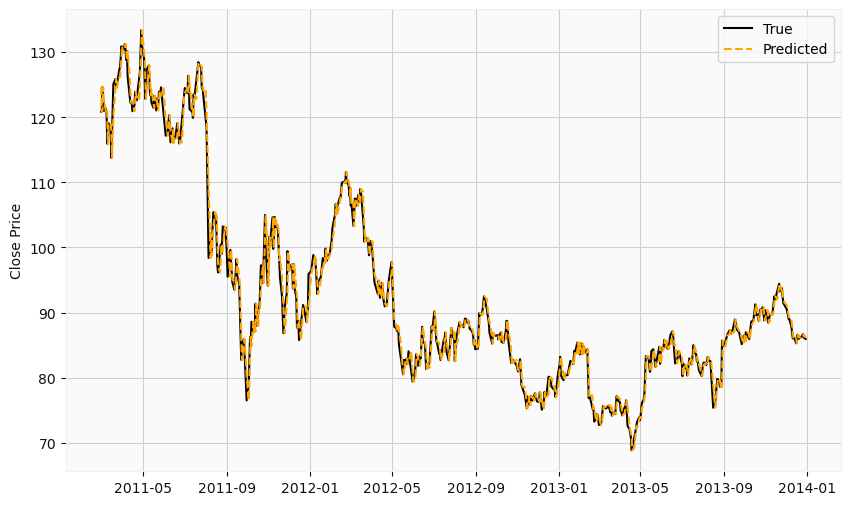

In [460]:
"""
Train Error
0.0010194057831540704
Validation Error
0.00034905970096588135
Test Error
0.0002793331805150956

This is a minimum benchmark for any machine learning!!! It is just taking the last day to predict the next day. :O
"""

model = Regression_LastValueModel("Close")
predictor = ModelPredictor(model, 10,  torch.nn.MSELoss())
print("Train Error")
print(predictor.evaluate(df_train))
print("Validation Error")
print(predictor.evaluate(df_validation))
print("Test Error")
print(predictor.evaluate(df_test))

predictor.predict_and_plot(df, "images/last_value_model.png")

## NN Models

In [462]:
class NetworkTrainer:
    def __init__(self, model, train_settings = TrainSettings(), network=None):
        self.model = model
        self.train_settings = train_settings
        self.network = network if network is not None else model.to(determine_device())
        self.optimizer = torch.optim.Adam(self.network.parameters(), lr=train_settings.LR)
        
    # batch is a time_steps x batch_size x features tensor
    def _train_on_batch(self, batch, targets):
        # eg. 20 x 64 if 20 is batchsize and 64 is hidden_size
        self.optimizer.zero_grad()
        output = self.network(batch)
        loss = self.train_settings.LOSS_FUNCTION(output, targets)
        loss.backward()
        self.optimizer.step()
        loss = loss.item()
        return loss

    def train_one_epoch(self, df):
        self.network.train()
        losses_all_batches = 0
        all_batches_size = 0

        for (i,(batch,targets)) in enumerate(batches_iterator(df, self.train_settings.BATCH_SIZE, self.train_settings.TIME_STEPS)):
            loss = self._train_on_batch(batch, targets)
            # each batch has shape: timesteps * batch_size * features
            all_batches_size += batch.shape[1]
            losses_all_batches += loss * batch.shape[1]
        
        return losses_all_batches / all_batches_size

    def evaluate_network(self, df):
        batch, targets = get_one_big_batch(df, self.train_settings.TIME_STEPS)
        self.network.eval()
        with torch.no_grad():
            output = self.network(batch)
            loss = self.train_settings.LOSS_FUNCTION(output, targets).item()
            return loss

    def train(self, df_train, df_validation, df_test):
        train_losses = []
        validation_losses = []
        EPOCHS = self.train_settings.EPOCHS
        for i in range(EPOCHS):
            train_loss = self.train_one_epoch(df_train)
            validation_loss = self.evaluate_network(df_validation)
            train_losses.append(train_loss)
            validation_losses.append(validation_loss)
            print(f"EPOCH {i+1}:: train_loss: {train_loss}, validation_loss: {validation_loss}")
        
        fig, ax = plt.subplots()
        ax.plot(range(1,EPOCHS+1),train_losses, label="train loss")
        ax.plot(range(1,EPOCHS+1),validation_losses, label="validation loss")
        ax.legend()
        plt.show()
        # print predictions:
        self.predict_on_new_data_and_plot(df_test)

    def predict_on_new_data(self,new_data_df):
        batch, targets = get_one_big_batch(new_data_df, self.train_settings.TIME_STEPS)
        self.network.eval()
        output = self.network(batch).detach()
        results_df = new_data_df[["Date", "CloseNext"]][self.train_settings.TIME_STEPS-1:].copy()
        results_df["CloseNextPredicted"] = output
        return results_df

    def predict_on_new_data_and_plot(self,new_data_df, savepath=None):
        results = self.predict_on_new_data(new_data_df)
        fig, ax = plt.subplots()
        real =   NUMERIC_FEATURES_NORM_REVERSE_FUNCS["Close"](results["CloseNext"])
        predicted = NUMERIC_FEATURES_NORM_REVERSE_FUNCS["Close"](results["CloseNextPredicted"])
        fig.set_size_inches(10,6)
        ax.plot(results.index, real, label="True", color="black")
        ax.plot(results.index, predicted, label="Predicted", linestyle='dashed', color="orange")
        ax.set_ylabel("Close Price")
        ax.legend()
        if(savepath != None):
            fig.savefig(savepath, format='png', dpi=150, bbox_inches='tight')
        plt.show()

### Model 1: Moving Average 30 Days:

In [463]:
class RegressionLearnedMAOfClose(nn.Module):
    # size_hidden is also size of cell
    def __init__(self, time_steps):
        super(RegressionLearnedMAOfClose, self).__init__()
        self.time_steps = time_steps
        self.ma_mapping = nn.Linear(time_steps, 1)
        self.init_weights()

    def init_weights(self):
        stdv = 1.0 / math.sqrt(self.time_steps)
        for weight in self.parameters():
            weight = torch.Tensor([0] * self.time_steps  + [1])

    def forward(self, batch):
        time_steps = batch.shape[0]
        assert time_steps == self.time_steps
        
        # time_steps x batches
        just_close = batch[:,:,3]

        # batches x time_steps
        just_close =  torch.permute(just_close,(1, 0))

        output = self.ma_mapping(just_close)
        return output

EPOCH 1:: train_loss: 0.100250711954676, validation_loss: 0.021423889324069023
EPOCH 2:: train_loss: 0.03683242442098953, validation_loss: 0.014620201662182808
EPOCH 3:: train_loss: 0.019174375294331403, validation_loss: 0.012142522260546684
EPOCH 4:: train_loss: 0.0175348533728448, validation_loss: 0.011575087904930115
EPOCH 5:: train_loss: 0.017462054522430555, validation_loss: 0.011623083613812923
EPOCH 6:: train_loss: 0.017016346940589948, validation_loss: 0.011672009713947773
EPOCH 7:: train_loss: 0.01669187760285394, validation_loss: 0.011524680070579052
EPOCH 8:: train_loss: 0.016409137695144786, validation_loss: 0.011265866458415985
EPOCH 9:: train_loss: 0.016117981508895585, validation_loss: 0.011003291234374046
EPOCH 10:: train_loss: 0.015820623196779203, validation_loss: 0.010763486847281456
EPOCH 11:: train_loss: 0.015515510607237505, validation_loss: 0.010530768893659115
EPOCH 12:: train_loss: 0.01520524485221734, validation_loss: 0.01029321737587452
EPOCH 13:: train_loss:

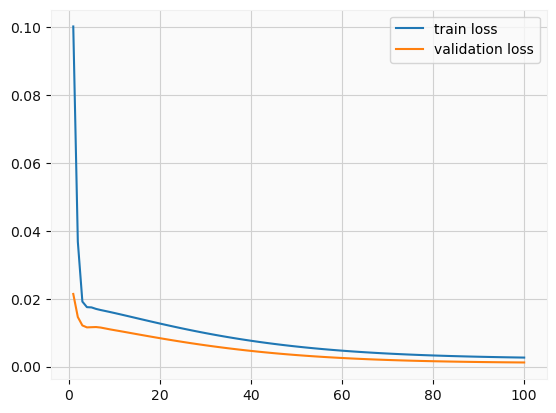

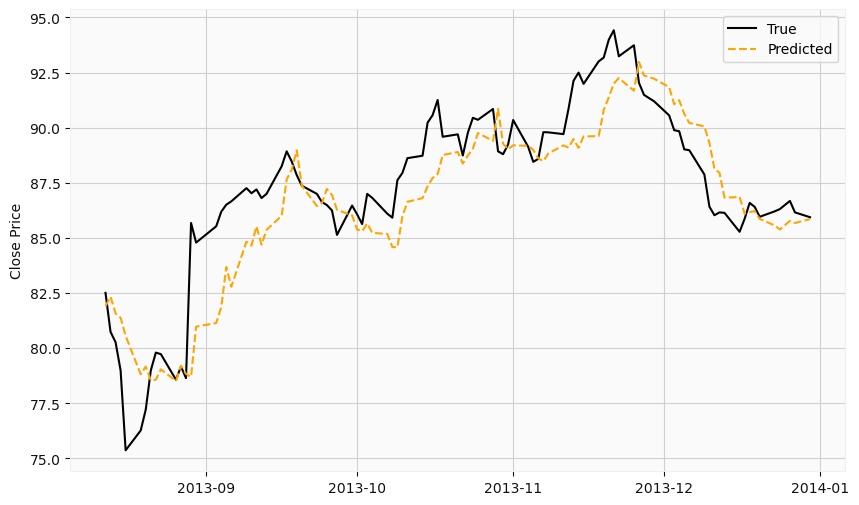

tensor(0.9772, grad_fn=<SumBackward0>)
tensor(0.0004, grad_fn=<SumBackward0>)


In [465]:
model = RegressionLearnedMAOfClose(time_steps=30)
trainsettings = TrainSettings(BATCH_SIZE=32, EPOCHS=100, LR=0.001, TIME_STEPS=30)
network_trainer = NetworkTrainer(model, trainsettings)
network_trainer.train_settings = trainsettings
network_trainer.train(df_train, df_validation, df_test)
network_ma = network_trainer.network

for p in network_ma.parameters():
    print(p.sum())

# Model 2: RNN

In [466]:
class Regression_RNN(nn.Module):
    def __init__(self, size_input, size_hidden):
        super(Regression_RNN, self).__init__()
        self.size_input = size_input
        self.size_hidden = size_hidden


        self.combined_to_hidden = nn.Linear(size_input + size_hidden, size_hidden)
        self.hidden_to_output = nn.Linear(size_hidden, 1)
        
        self.init_weights()
    
    def init_weights(self):
        stdv = 1.0 / math.sqrt(self.size_hidden)
        for weight in self.parameters():
            weight.data.uniform_(-stdv, stdv)

    def single_forward(self, batch_time_slice, hidden_state):
        """batch_time_slice is tensor of batch_size x features"""
        combined = torch.cat((batch_time_slice,hidden_state),dim=1)
        hidden = nn.functional.relu(self.combined_to_hidden(combined))
        output = self.hidden_to_output(hidden)
        
        return output, hidden

    def forward(self, batch):
        time_steps = batch.shape[0]
        next_hidden = torch.zeros((batch.shape[1], self.size_hidden)).float()
        output = None
        for t in range(time_steps):
            output, next_hidden = self.single_forward(batch[t,:,:], next_hidden)
        return output

In [467]:
class Regression_LSTM(nn.Module):
    # size_hidden is also size of cell
    def __init__(self, size_input, size_hidden):
        super(Regression_LSTM, self).__init__()
        self.size_input = size_input
        self.size_hidden = size_hidden

        self.forget_gate = nn.Linear(size_input + size_hidden, size_hidden)
        self.input_update_gate = nn.Linear(size_input + size_hidden, size_hidden)
        self.output_gate = nn.Linear(size_input + size_hidden, size_hidden)
        self.cell_input_activation = nn.Linear(size_input + size_hidden, size_hidden)

        self.hidden_to_output = nn.Linear(size_hidden, 1)
        
        self.init_weights()

    def init_weights(self):
        stdv = 1.0 / math.sqrt(self.size_hidden)
        for weight in self.parameters():
            weight.data.uniform_(-stdv, stdv)

    def single_forward(self, batch_time_slice, hidden_state, cell_state):
        """batch_time_slice is tensor of batch_size x features"""
        # the inputs in each iteration are combined and cell state
        combined = torch.cat((batch_time_slice,hidden_state),dim=1)

        ft = torch.sigmoid(self.forget_gate(combined))
        it = torch.sigmoid(self.input_update_gate(combined))
        ot = torch.sigmoid(self.output_gate(combined))
        ct_tilde = torch.tanh(self.cell_input_activation(combined))
        ct = torch.add(torch.mul(ft, cell_state),torch.mul(it, ct_tilde))
        ht = torch.mul(ot, torch.tanh(ct))
        output = self.hidden_to_output(ht)
        
        return output, ht, ct

    def forward(self, batch):
        time_steps = batch.shape[0]
        next_hidden = torch.zeros((batch.shape[1], self.size_hidden)).float()
        next_cell = torch.zeros((batch.shape[1], self.size_hidden)).float()
        output = None
        for t in range(time_steps):
            output, next_hidden, next_cell = self.single_forward(batch[t,:,:], next_hidden, next_cell)
        return output

In [468]:
class Regression_GRU(nn.Module):
    # size_hidden is also size of cell
    def __init__(self, size_input, size_hidden):
        super(Regression_GRU, self).__init__()
        self.size_input = size_input
        self.size_hidden = size_hidden

        self.z_gate = nn.Linear(size_input + size_hidden, size_hidden)
        self.r_gate = nn.Linear(size_input + size_hidden, size_hidden)
        self.h_gate = nn.Linear(size_input + size_hidden, size_hidden)
       
        self.hidden_to_output = nn.Linear(size_hidden, 1)
        
        self.init_weights()

    def init_weights(self):
        stdv = 1.0 / math.sqrt(self.size_hidden)
        for weight in self.parameters():
            weight.data.uniform_(-stdv, stdv)

    def single_forward(self, batch_time_slice, hidden_state):
        """batch_time_slice is tensor of batch_size x features"""
        # the inputs in each iteration are combined and cell state
        combined = torch.cat((batch_time_slice,hidden_state),dim=1)

        zt = torch.sigmoid(self.z_gate(combined))
        rt = torch.sigmoid(self.r_gate(combined))

        combined_2 = torch.cat((batch_time_slice, torch.mul(rt,hidden_state)), dim=1)
        ht_hat = torch.tanh(self.h_gate(combined_2))
        ht =  torch.add(torch.mul(zt, ht_hat),torch.mul(torch.add(torch.mul(zt,-1),1), hidden_state))

        output = self.hidden_to_output(ht)
        
        return output, ht

    def forward(self, batch):
        time_steps = batch.shape[0]
        next_hidden = torch.zeros((batch.shape[1], self.size_hidden)).float()
        output = None
        for t in range(time_steps):
            output, next_hidden = self.single_forward(batch[t,:,:], next_hidden)
        return output

EPOCH 1:: train_loss: 0.2244016668122287, validation_loss: 0.002849876182153821
EPOCH 2:: train_loss: 0.05795136810559989, validation_loss: 0.044132087379693985
EPOCH 3:: train_loss: 0.008745360398416998, validation_loss: 0.010734009556472301
EPOCH 4:: train_loss: 0.01242642470637576, validation_loss: 0.012689271941781044
EPOCH 5:: train_loss: 0.006040189711641915, validation_loss: 0.0079553397372365
EPOCH 6:: train_loss: 0.0035523529854050205, validation_loss: 0.004219268914312124
EPOCH 7:: train_loss: 0.0025139754873534357, validation_loss: 0.002485096687451005
EPOCH 8:: train_loss: 0.0022734701612430286, validation_loss: 0.002011425094678998
EPOCH 9:: train_loss: 0.0022961807223856787, validation_loss: 0.0018967150244861841
EPOCH 10:: train_loss: 0.0021016899602483478, validation_loss: 0.001813043374568224
EPOCH 11:: train_loss: 0.0020293994537611444, validation_loss: 0.0016605325508862734
EPOCH 12:: train_loss: 0.0019940511209461374, validation_loss: 0.0015319206286221743
EPOCH 13:

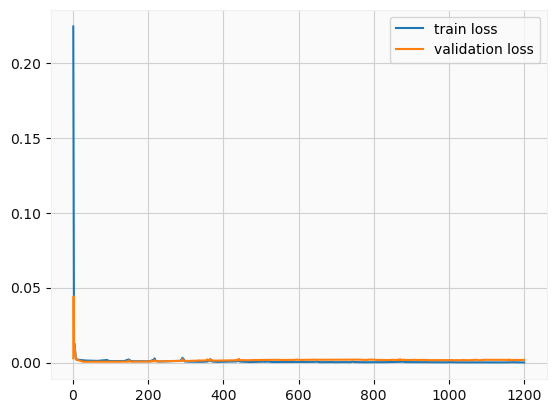

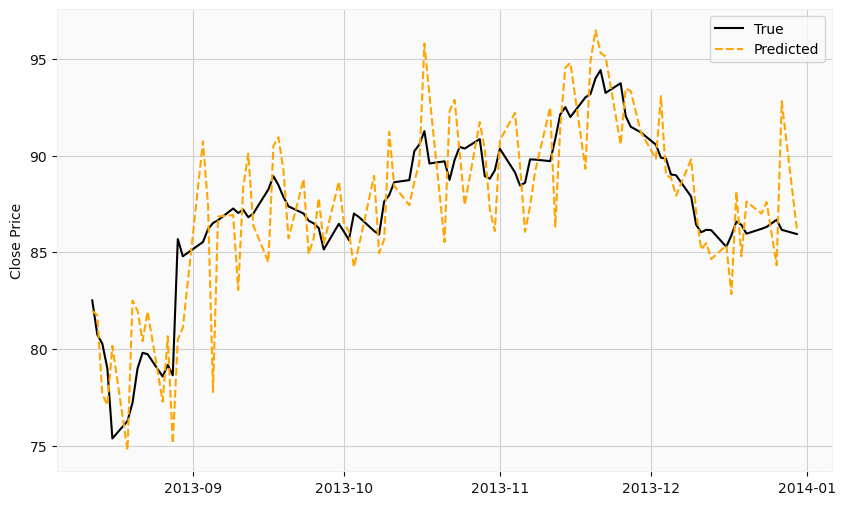

In [470]:
model = Regression_RNN(17, 64)
trainsettings = TrainSettings(BATCH_SIZE=32, EPOCHS=1200, LR=0.001)
# EPOCH 2400: 0.0001: train_loss: 8.6927776272087, validation_loss: 3.734614849090576
# EPOCH 1200: 0.001: train_loss: 10.333832607312342, validation_loss: 3.538003444671631
network_trainer = NetworkTrainer(model, trainsettings)
network_trainer.train(df_train, df_validation, df_test)
network_manual = network_trainer.network
torch.save(network_manual.state_dict(), "1200RNN")

EPOCH 1:: train_loss: 0.22572468761809308, validation_loss: 0.0020903225522488356
EPOCH 2:: train_loss: 0.04784436279205652, validation_loss: 0.03771763667464256
EPOCH 3:: train_loss: 0.00525251421741048, validation_loss: 0.007613239344209433
EPOCH 4:: train_loss: 0.013224726664764349, validation_loss: 0.01174198929220438
EPOCH 5:: train_loss: 0.0040024029549303765, validation_loss: 0.004439918790012598
EPOCH 6:: train_loss: 0.003945501407705096, validation_loss: 0.003485514549538493
EPOCH 7:: train_loss: 0.002595147188399702, validation_loss: 0.0017779063200578094
EPOCH 8:: train_loss: 0.002603361093487515, validation_loss: 0.0021903819870203733
EPOCH 9:: train_loss: 0.003148190351570988, validation_loss: 0.0016866786172613502
EPOCH 10:: train_loss: 0.0027999997272473627, validation_loss: 0.0022935052402317524
EPOCH 11:: train_loss: 0.0026532902834836064, validation_loss: 0.0016571673331782222
EPOCH 12:: train_loss: 0.0023969102878981263, validation_loss: 0.001892432919703424
EPOCH 13

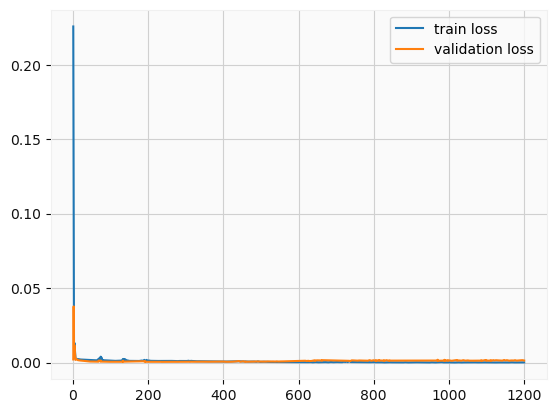

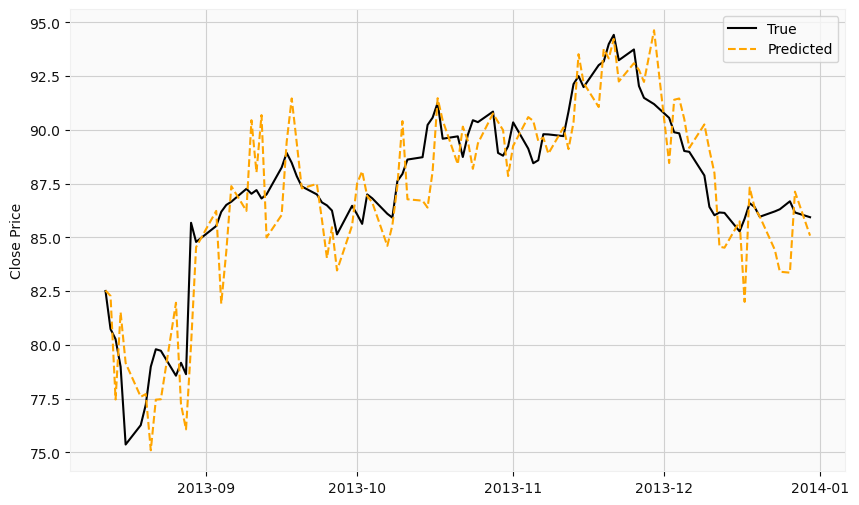

In [471]:
model = Regression_LSTM(17, 64)
trainsettings = TrainSettings(BATCH_SIZE=32, EPOCHS=1200, LR=0.001)
network_trainer = NetworkTrainer(model, trainsettings)
network_trainer.train(df_train, df_validation, df_test)
network_lstm = network_trainer.network
torch.save(network_manual.state_dict(), "1200LSTM")

EPOCH 1:: train_loss: 9464.004161963883, validation_loss: 5463.7177734375
EPOCH 2:: train_loss: 8614.275074289291, validation_loss: 4943.89404296875
EPOCH 3:: train_loss: 8007.759137362444, validation_loss: 4507.41357421875
EPOCH 4:: train_loss: 7475.473154451185, validation_loss: 4119.74755859375
EPOCH 5:: train_loss: 6991.679857792219, validation_loss: 3766.455810546875
EPOCH 6:: train_loss: 6543.454612439158, validation_loss: 3440.70166015625
EPOCH 7:: train_loss: 6124.447673444554, validation_loss: 3138.761474609375
EPOCH 8:: train_loss: 5731.025887172863, validation_loss: 2858.235595703125
EPOCH 9:: train_loss: 5360.783857840716, validation_loss: 2597.38525390625
EPOCH 10:: train_loss: 5011.957371834438, validation_loss: 2354.84716796875
EPOCH 11:: train_loss: 4683.154620375106, validation_loss: 2129.486572265625
EPOCH 12:: train_loss: 4373.216752235292, validation_loss: 1920.317626953125
EPOCH 13:: train_loss: 4081.138526933726, validation_loss: 1726.456787109375
EPOCH 14:: train

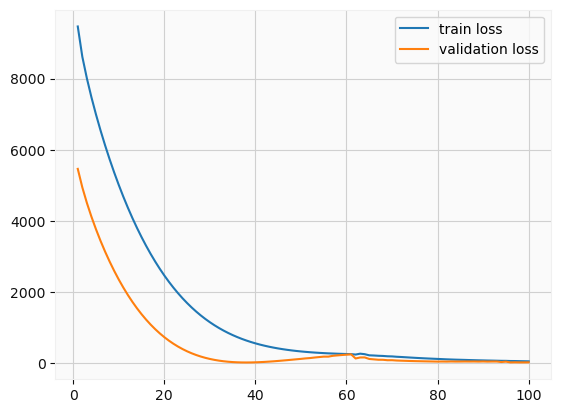

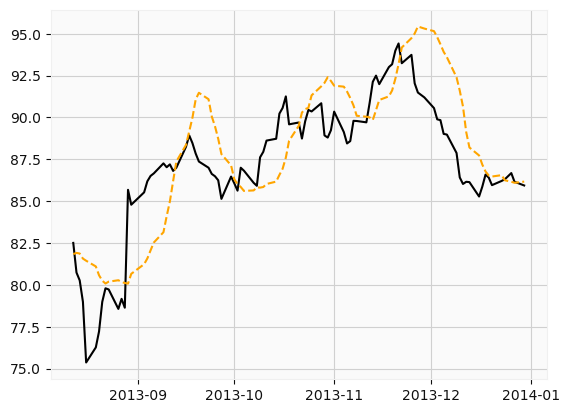

In [197]:
model = Regression_GRU(15, 32)
trainsettings = TrainSettings(BATCH_SIZE=16, EPOCHS=100, LR=0.003) # 32 hidden layers, BATCH_SIZE=16, EPOCHS=500, LR=0.001
network_trainer = NetworkTrainer(model, trainsettings)
network_trainer.train(df_train, df_validation, df_test)
network_gru = network_trainer.network

In [418]:

class FullyConnected2HiddenLayers(nn.Module):
    # size_hidden is also size of cell
    def __init__(self, time_steps, features, hidden_size):
        super(FullyConnected2HiddenLayers, self).__init__()
        self.time_steps = time_steps
        self.features = features
        self.hidden_size = hidden_size
        self.i_to_h = nn.Linear(time_steps*features, hidden_size)
        self.h_to_h2 = nn.Linear(hidden_size, hidden_size)
        self.h2_to_o = nn.Linear(hidden_size, 1)
        self.init_weights()

    def init_weights(self):
        stdv = 1.0 / math.sqrt(self.time_steps)
        for weight in self.parameters():
            weight.data.uniform_(0,stdv)

    def forward(self, batch):
        time_steps = batch.shape[0]
        assert time_steps == self.time_steps
        features = batch.shape[2]
        assert features == self.features

        batch = torch.permute(batch,(1,0,2))
        # print(batch.shape)
        flattened_batch = torch.flatten(batch, start_dim=1, end_dim=2) # should give batchsize x (time_steps*features)
        # print(flattened_batch.shape)
        h1 = torch.relu(self.i_to_h(flattened_batch))
        h2 = torch.relu(self.h_to_h2(h1))
        output = self.h2_to_o(h2)
        return output

EPOCH 1:: train_loss: 0.0010932912697524681, validation_loss: 0.0022051518317312002
EPOCH 2:: train_loss: 0.0014556971216910944, validation_loss: 0.0018950456287711859
EPOCH 3:: train_loss: 0.0007158722067906145, validation_loss: 0.0025640681851655245
EPOCH 4:: train_loss: 0.0016584856423568276, validation_loss: 0.0034748190082609653
EPOCH 5:: train_loss: 0.00072982322465908, validation_loss: 0.0026772399432957172
EPOCH 6:: train_loss: 0.0015978064996819222, validation_loss: 0.001938244211487472
EPOCH 7:: train_loss: 0.0008744214648017176, validation_loss: 0.002080125268548727
EPOCH 8:: train_loss: 0.0013078180214408028, validation_loss: 0.0031612426973879337
EPOCH 9:: train_loss: 0.0011771771004744102, validation_loss: 0.003221316495910287
EPOCH 10:: train_loss: 0.001060533738622424, validation_loss: 0.0022332235239446163
EPOCH 11:: train_loss: 0.0014468908045374164, validation_loss: 0.0019103732192888856
EPOCH 12:: train_loss: 0.0006998277050992222, validation_loss: 0.002564217196777

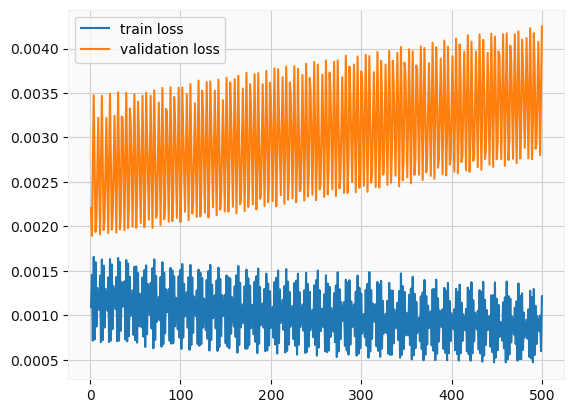

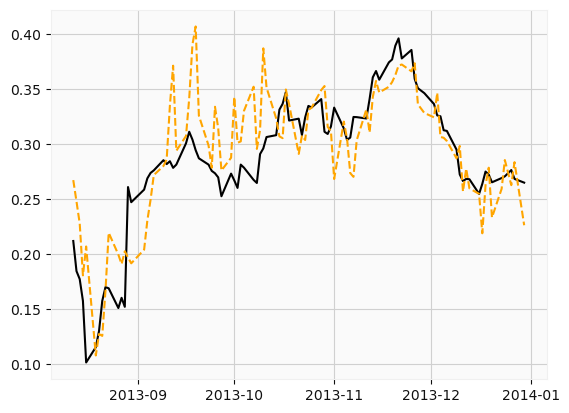

In [424]:
model = FullyConnected2HiddenLayers(time_steps=30, features=17, hidden_size=10)
trainsettings = TrainSettings(BATCH_SIZE=32, EPOCHS=500, LR=0.0001, TIME_STEPS=30)
# network_trainer = NetworkTrainer(model, trainsettings)
network_trainer.train_settings = trainsettings
network_trainer.train(df_train, df_validation, df_test)
network_fully_connected = network_trainer.network

EPOCH 1:: train_loss: 0.10374184037846751, validation_loss: 0.005636714864522219
EPOCH 2:: train_loss: 0.04918371009772841, validation_loss: 0.021759243682026863
EPOCH 3:: train_loss: 0.012131299883963931, validation_loss: 0.0025493702851235867
EPOCH 4:: train_loss: 0.011666809517401953, validation_loss: 0.0013830977259203792
EPOCH 5:: train_loss: 0.00489608164662264, validation_loss: 0.005289117805659771
EPOCH 6:: train_loss: 0.0026560439521254465, validation_loss: 0.0010257146786898375
EPOCH 7:: train_loss: 0.009203997633522944, validation_loss: 0.00303675071336329
EPOCH 8:: train_loss: 0.007493986182835092, validation_loss: 0.0015142376068979502
EPOCH 9:: train_loss: 0.0025813714681249995, validation_loss: 0.00132443115580827
EPOCH 10:: train_loss: 0.006035167935438891, validation_loss: 0.002313211327418685
EPOCH 11:: train_loss: 0.0034102880473208716, validation_loss: 0.0013909932458773255
EPOCH 12:: train_loss: 0.003497358366613682, validation_loss: 0.0008690422400832176
EPOCH 13:

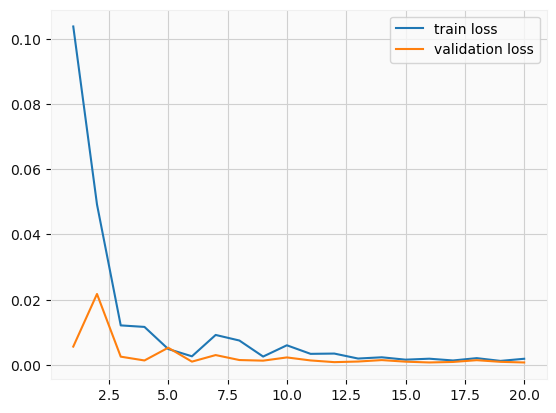

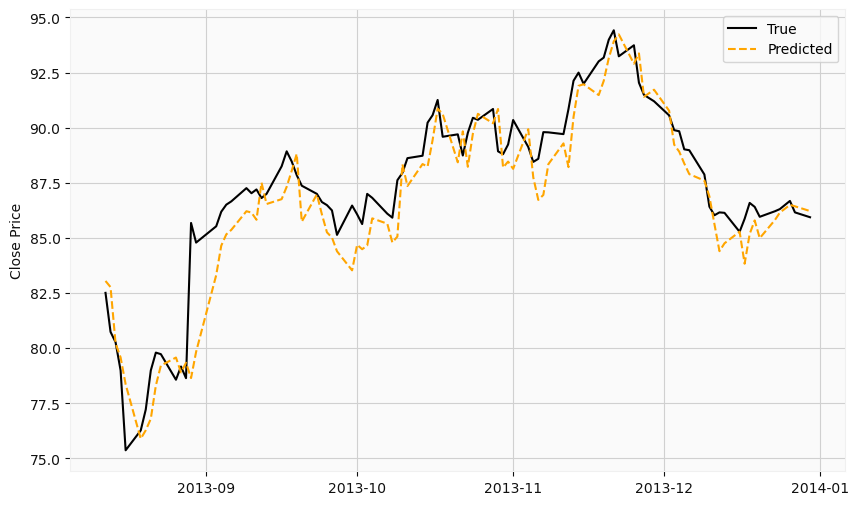

In [475]:
model = Regression_RNN(17, 64)
trainsettings = TrainSettings(BATCH_SIZE=32, EPOCHS=20, LR=0.01)
network_trainer = NetworkTrainer(model, trainsettings)
network_trainer.train(df_train, df_validation, df_test)
# network_manual = network_trainer.network
# torch.save(network_manual.state_dict(), "1200RNN")

EPOCH 1:: train_loss: 0.054554327850179586, validation_loss: 0.003932110033929348
EPOCH 2:: train_loss: 0.04636883073009164, validation_loss: 0.02298326976597309
EPOCH 3:: train_loss: 0.0032056761463015063, validation_loss: 0.0023501687683165073
EPOCH 4:: train_loss: 0.00523085406954867, validation_loss: 0.001434164121747017
EPOCH 5:: train_loss: 0.0028908924918630186, validation_loss: 0.0029470818117260933
EPOCH 6:: train_loss: 0.0014882030748104168, validation_loss: 0.0012352459598332644
EPOCH 7:: train_loss: 0.0013216703743348004, validation_loss: 0.0012812770437449217
EPOCH 8:: train_loss: 0.001427179749300346, validation_loss: 0.001209866488352418
EPOCH 9:: train_loss: 0.0012230400911071937, validation_loss: 0.0009666146361269057
EPOCH 10:: train_loss: 0.0012490972690625878, validation_loss: 0.0009420753340236843
EPOCH 11:: train_loss: 0.0011660878503307254, validation_loss: 0.000888200243934989
EPOCH 12:: train_loss: 0.0011577898803725208, validation_loss: 0.000868563016410917
EP

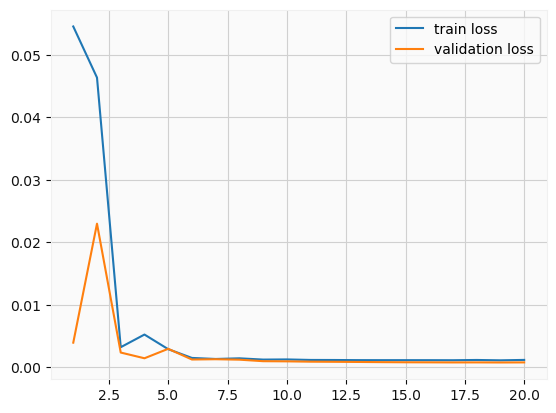

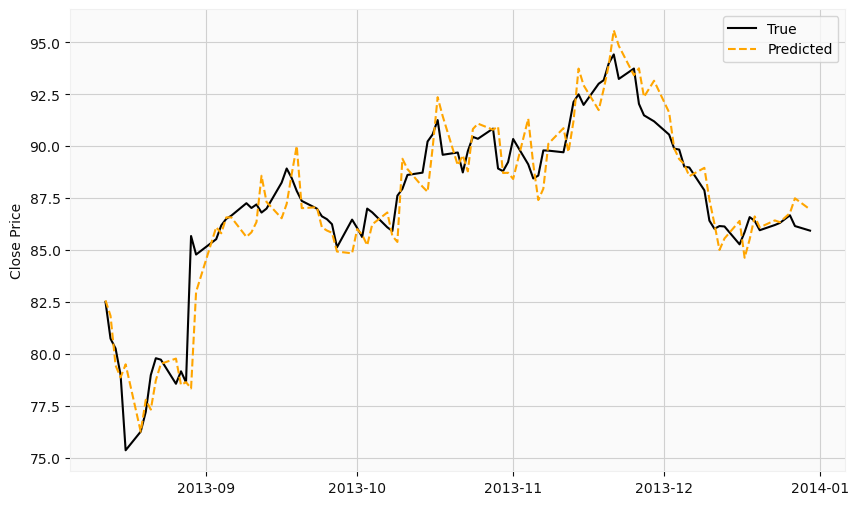

In [476]:
model = Regression_RNN(17, 32)
trainsettings = TrainSettings(BATCH_SIZE=32, EPOCHS=20, LR=0.01)
network_trainer = NetworkTrainer(model, trainsettings)
network_trainer.train(df_train, df_validation, df_test)

EPOCH 1:: train_loss: 0.25731047785958655, validation_loss: 0.00825000274926424
EPOCH 2:: train_loss: 0.10550210367190246, validation_loss: 0.014591452665627003
EPOCH 3:: train_loss: 0.026705694016968963, validation_loss: 0.03511213883757591
EPOCH 4:: train_loss: 0.00694016092004881, validation_loss: 0.014807750470936298
EPOCH 5:: train_loss: 0.010232940951097362, validation_loss: 0.014745043590664864
EPOCH 6:: train_loss: 0.005869723141664307, validation_loss: 0.011626644991338253
EPOCH 7:: train_loss: 0.004125187795769011, validation_loss: 0.008527188561856747
EPOCH 8:: train_loss: 0.0037174335771301263, validation_loss: 0.007311432156711817
EPOCH 9:: train_loss: 0.0030867867613249118, validation_loss: 0.006081587169319391
EPOCH 10:: train_loss: 0.0029031846632352667, validation_loss: 0.0058195278979837894
EPOCH 11:: train_loss: 0.0026701111299181294, validation_loss: 0.005212072283029556
EPOCH 12:: train_loss: 0.0025233962351317533, validation_loss: 0.005152152385562658
EPOCH 13:: t

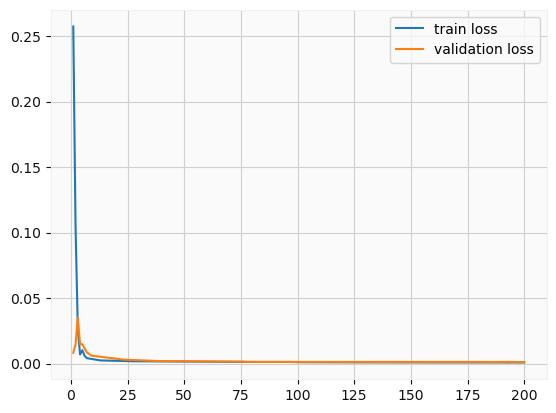

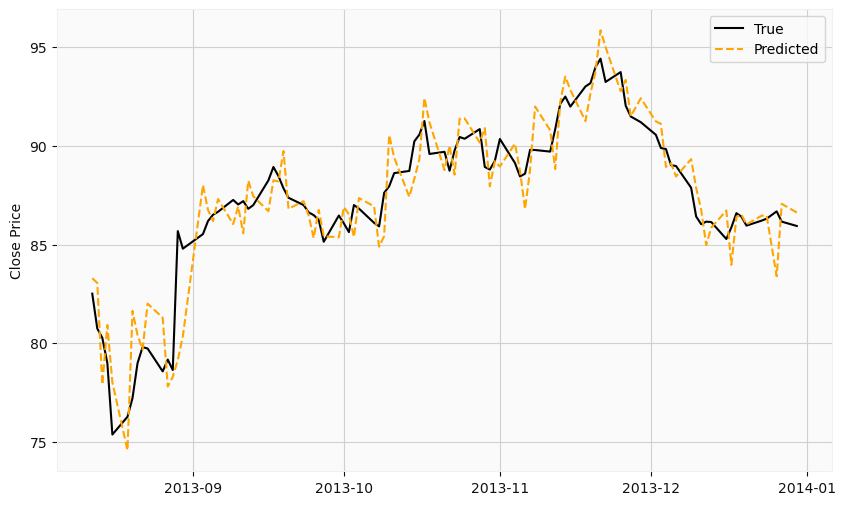

In [477]:
model = Regression_RNN(17, 32)
trainsettings = TrainSettings(BATCH_SIZE=32, EPOCHS=200, LR=0.001)
network_trainer = NetworkTrainer(model, trainsettings)
network_trainer.train(df_train, df_validation, df_test)

EPOCH 1:: train_loss: 0.1973906807921003, validation_loss: 0.020997243002057076
EPOCH 2:: train_loss: 0.02482548075187825, validation_loss: 0.01817019283771515
EPOCH 3:: train_loss: 0.0091717551876507, validation_loss: 0.010350567288696766
EPOCH 4:: train_loss: 0.009141770073761386, validation_loss: 0.011244983412325382
EPOCH 5:: train_loss: 0.004037768766073758, validation_loss: 0.005086344201117754
EPOCH 6:: train_loss: 0.004084373868446856, validation_loss: 0.004152927082031965
EPOCH 7:: train_loss: 0.0022894813593489624, validation_loss: 0.001934786094352603
EPOCH 8:: train_loss: 0.002124025215737471, validation_loss: 0.0013704242883250117
EPOCH 9:: train_loss: 0.0019576605711590592, validation_loss: 0.0013811199460178614
EPOCH 10:: train_loss: 0.0019724236741613674, validation_loss: 0.0012395320227369666
EPOCH 11:: train_loss: 0.0018399501012840032, validation_loss: 0.0012653927551582456
EPOCH 12:: train_loss: 0.0017738791307987346, validation_loss: 0.001159827341325581
EPOCH 13::

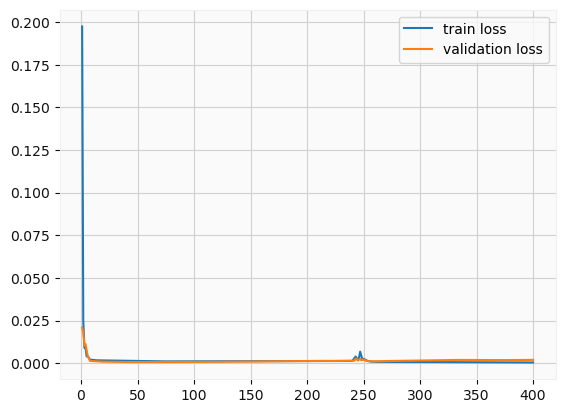

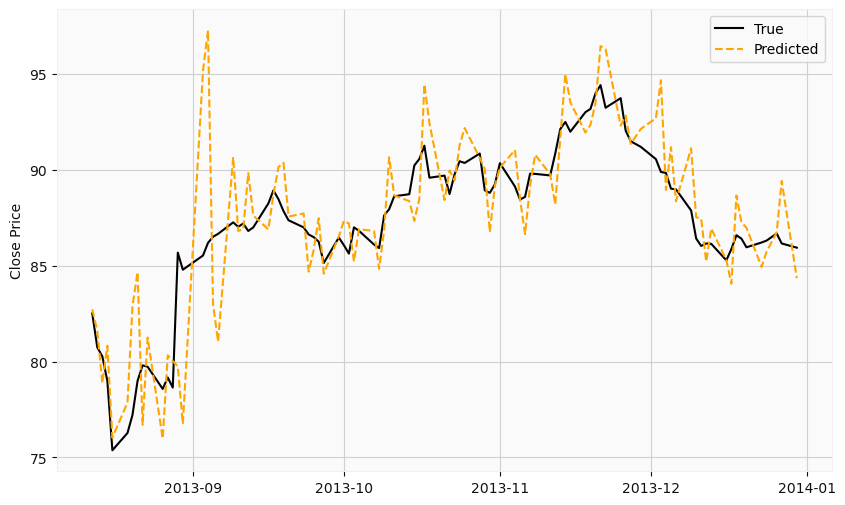

In [479]:
model = Regression_RNN(17, 64)
trainsettings = TrainSettings(BATCH_SIZE=32, EPOCHS=400, LR=0.001)
network_trainer = NetworkTrainer(model, trainsettings)
network_trainer.train(df_train, df_validation, df_test)